<a href="https://colab.research.google.com/github/PIYAL-DATTA/Multi-attack/blob/main/NSL_KDD_Origin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Detecting traditional intrusions (e.g. DDoS, port scans) and even “zero‑day" (previously unseen) attacks from the NSL‑KDD dataset is absolutely possible—but we will need to combine both supervised classification (for known attack types) and anomaly/novelty detection (for zero‑days).**

# Install requirements

1. Import libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os

2. Load NSL-KDD dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("hassan06/nslkdd")

print("Path to dataset files:", path)

train_path = os.path.join(path, "KDDTrain+.txt")
test_path  = os.path.join(path, "KDDTest+.txt")

print("Path to Train dataset files:", train_path)
print("Path to Test dataset files:", test_path)

column_names = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate',
    'srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate',
    'dst_host_srv_rerror_rate','label','difficulty_level'
]

train_df = pd.read_csv(train_path, names=column_names)
test_df = pd.read_csv(test_path, names=column_names)

Using Colab cache for faster access to the 'nslkdd' dataset.
Path to dataset files: /kaggle/input/nslkdd
Path to Train dataset files: /kaggle/input/nslkdd/KDDTrain+.txt
Path to Test dataset files: /kaggle/input/nslkdd/KDDTest+.txt


3. Encode categorical features

In [ ]:
print(len(train_df.columns))

43


In [ ]:
categorical_cols = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_cols:
    enc = LabelEncoder()
    train_df[col] = enc.fit_transform(train_df[col])
    test_df[col] = enc.transform(test_df[col])
    encoders[col] = enc

4. Encode labels into categories (normal, DoS, Probe, etc.)

In [ ]:
train_df['label'].value_counts()

,count
label,
normal,67343
neptune,41214
satan,3633
ipsweep,3599
portsweep,2931
smurf,2646
nmap,1493
back,956
teardrop,892


In [ ]:
def map_attack(label):
    dos = ['back','land','neptune','pod','smurf','teardrop','mailbomb','apache2','processtable','udpstorm']
    probe = ['satan','ipsweep','nmap','portsweep','mscan','saint']
    r2l = ['guess_passwd','ftp_write','imap','phf','multihop','warezmaster','warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack','httptunnel','sendmail','named']
    u2r = ['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps']

    if label == 'normal': return 0 # 'normal'
    elif label in dos: return 1 # 'DoS'
    elif label in probe: return 2 # 'Probe'
    elif label in r2l: return 2 # 'R2L'
    elif label in u2r: return 2 # 'U2R'
    else: return 2 # 'unknown'
# 2 represent BotNet attack.
# 'Probe' Early stage, 'R2L' and 'U2R' attack phase

train_df['attack_class'] = train_df['label'].apply(map_attack)
test_df['attack_class']  = test_df['label'].apply(map_attack)

In [ ]:
train_df['attack_class'].value_counts()

,count
attack_class,
0,67343
1,45927
2,12703


In [ ]:
test_df['attack_class'].value_counts()

,count
attack_class,
0,9711
1,7458
2,5375


5. Prepare data for supervised classification

In [ ]:
# X_train = train_df.drop(['label', 'attack_class'], axis=1)
# y_train = train_df['attack_class']
# X_test = test_df.drop(['label', 'attack_class'], axis=1)
# y_test = test_df['attack_class']

df = pd.concat([train_df, test_df], ignore_index=True)
X_reshaped = df.drop(['label', 'attack_class'], axis=1)
Y_reshaped = df['attack_class']
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, Y_reshaped, test_size=0.2, random_state=42)

# Normalize numeric data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

6. Train Random Forest Classifier

In [ ]:
# clf = RandomForestClassifier(n_estimators=200, random_state=42)
# clf.fit(X_train_scaled, y_train)

clf = RandomForestClassifier(
    n_estimators=300,          # more trees for stability
    max_depth=None,           # let trees expand fully
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',      # good default for classification
    class_weight='balanced',  # handle class imbalance
    random_state=42,
    n_jobs=-1                 # use all CPU cores
)
clf.fit(X_train_scaled, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=300, n_jobs=-1,
                       random_state=42)

# Predict and evaluate

In [ ]:
y_pred = clf.predict(X_test_scaled)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4, zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           0     0.9992    0.9994    0.9993     15450
           1     0.9995    0.9994    0.9995     10687
           2     0.9975    0.9969    0.9972      3567

    accuracy                         0.9991     29704
   macro avg     0.9987    0.9986    0.9986     29704
weighted avg     0.9991    0.9991    0.9991     29704



/tmp/ipython-input-1126080238.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')


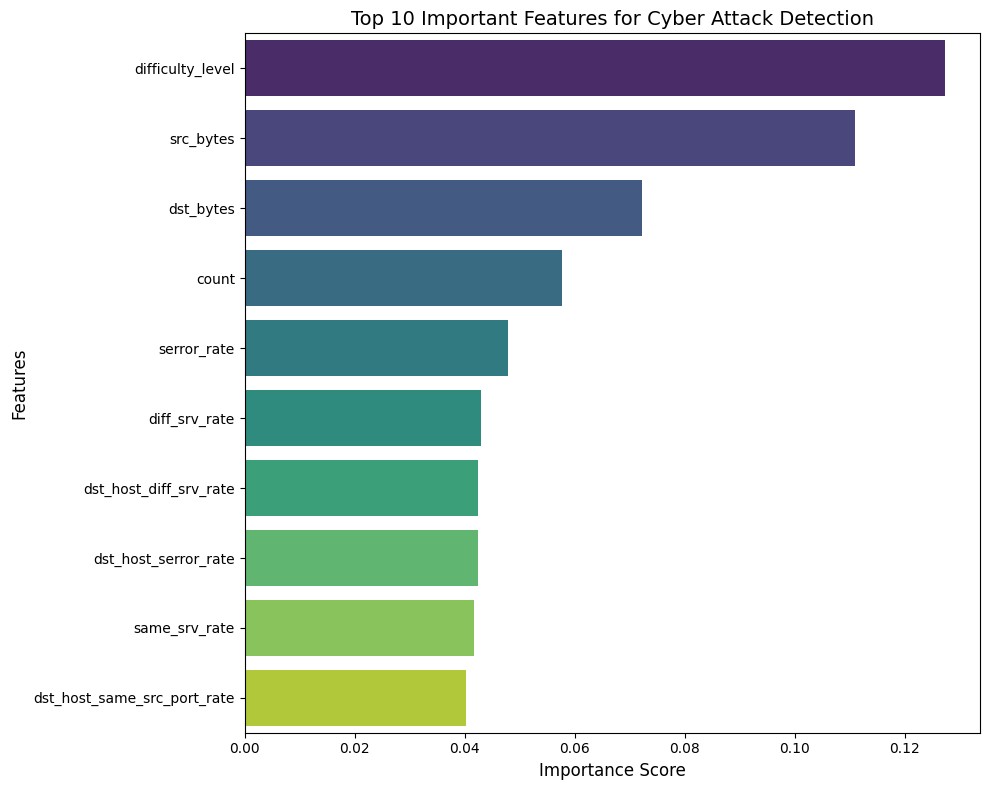

In [ ]:
# Plot feature importances (add this after RF evaluation)
# importances = pd.Series(clf.feature_importances_, index=X_train.columns)
# importances.sort_values(ascending=False, inplace=True)

# plt.figure(figsize=(10, 8))
# sns.barplot(x=importances.values, y=importances.index, palette='viridis')
# plt.title("Top Important Features for Cyber Attack Detection", fontsize=14)
# plt.xlabel("Importance Score", fontsize=12)
# plt.ylabel("Features", fontsize=12)
# plt.tight_layout()
# plt.savefig('feature_importance.png')
# plt.show()

# Plot TOP 15 feature importances
importances = pd.Series(clf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False, inplace=True)
top_15 = importances.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x=top_15.values, y=top_15.index, palette='viridis')
plt.title("Top 10 Important Features for Cyber Attack Detection", fontsize=14)
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance_top10.png')
plt.show()

# Xgboost

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.1,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',  # faster
    random_state=42
)
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, digits=4, zero_division=0))

              precision    recall  f1-score   support

           0     0.9994    0.9991    0.9993     15450
           1     0.9995    0.9997    0.9996     10687
           2     0.9969    0.9978    0.9973      3567

    accuracy                         0.9992     29704
   macro avg     0.9986    0.9989    0.9987     29704
weighted avg     0.9992    0.9992    0.9992     29704



# Plot confusion matrix

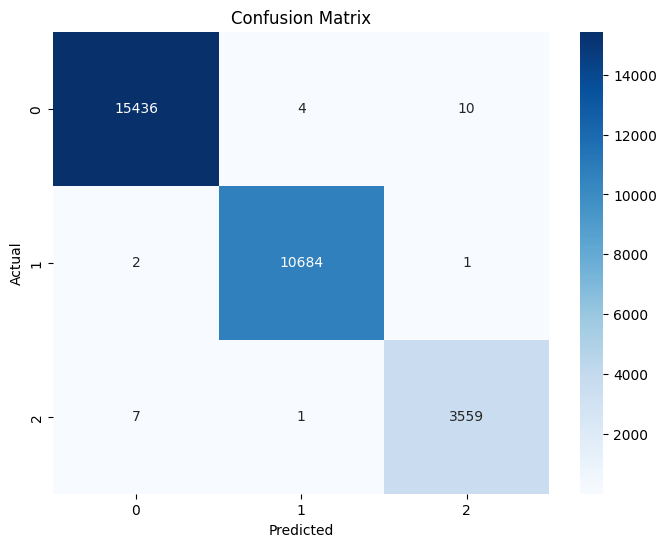

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

7. Anomaly Detection (simulate zero-day)

# Train Isolation Forest on normal traffic only

In [ ]:
X_train_normal = X_train[df['attack_class'] == 0]
X_train_normal_scaled = scaler.fit_transform(X_train_normal)

# iso_forest = IsolationForest(contamination=0.05, random_state=42)
# iso_forest.fit(X_train_normal_scaled)

iso_forest = IsolationForest(
    n_estimators=300,       # more estimators
    max_samples='auto',     # use all samples
    contamination=0.1,      # expected proportion of anomalies (tune this)
    max_features=1.0,       # use all features
    random_state=42,
    n_jobs=-1
)
iso_forest.fit(X_train_normal_scaled)
# IsolationForest outputs -1 for anomaly and 1 for normal

/tmp/ipython-input-1322018993.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train_normal = X_train[df['attack_class'] == 0]


IsolationForest(contamination=0.1, n_estimators=300, n_jobs=-1, random_state=42)

# Predict anomalies in test set

In [ ]:
X_test_scaled = scaler.transform(X_test)
anomaly_preds = iso_forest.predict(X_test_scaled)

# Map: -1 = anomaly, 1 = normal

In [ ]:
anomaly_labels = [1 if p == -1 else 0 for p in anomaly_preds]

# Evaluate how well anomaly detector detects attacks

In [ ]:
true_binary = [0 if label == 0 else 1 for label in y_test]
print("\nAnomaly Detection Report:")
print(classification_report(true_binary, anomaly_labels, digits=4, zero_division=0))


Anomaly Detection Report:
              precision    recall  f1-score   support

           0     0.9064    0.8980    0.9022     15450
           1     0.8905    0.8995    0.8950     14254

    accuracy                         0.8987     29704
   macro avg     0.8985    0.8988    0.8986     29704
weighted avg     0.8988    0.8987    0.8988     29704



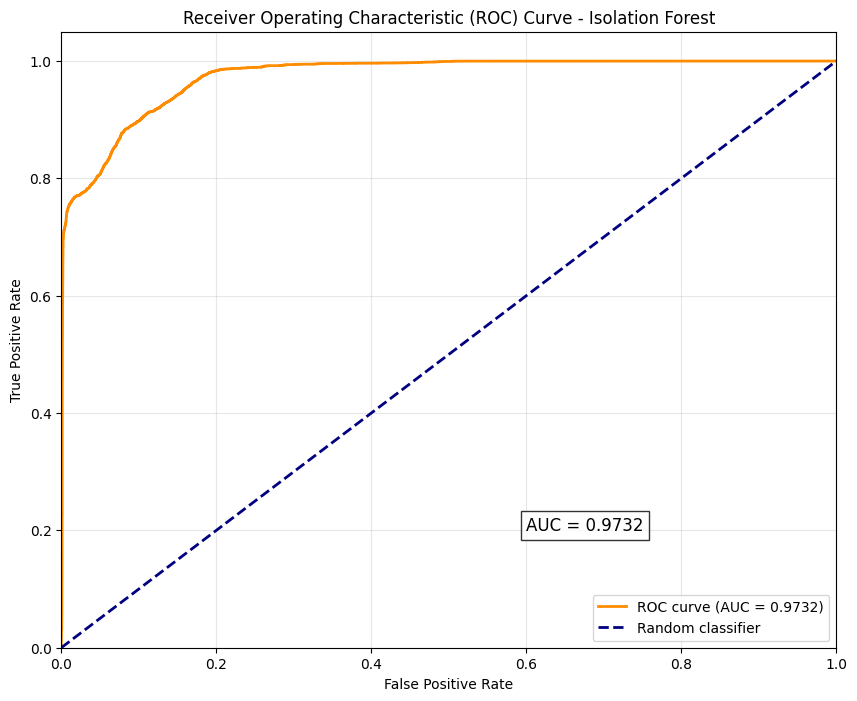

In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split

# Get decision scores (anomaly scores) instead of binary predictions
anomaly_scores = iso_forest.decision_function(X_test_scaled)

# Convert to positive scores (higher = more anomalous)
# Isolation Forest returns negative scores for anomalies, so we invert them
anomaly_scores_positive = -anomaly_scores

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(true_binary, anomaly_scores_positive)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Isolation Forest')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Add some additional information
plt.text(0.6, 0.2, f'AUC = {roc_auc:.4f}', fontsize=12,
         bbox=dict(facecolor='white', alpha=0.8))

plt.show()

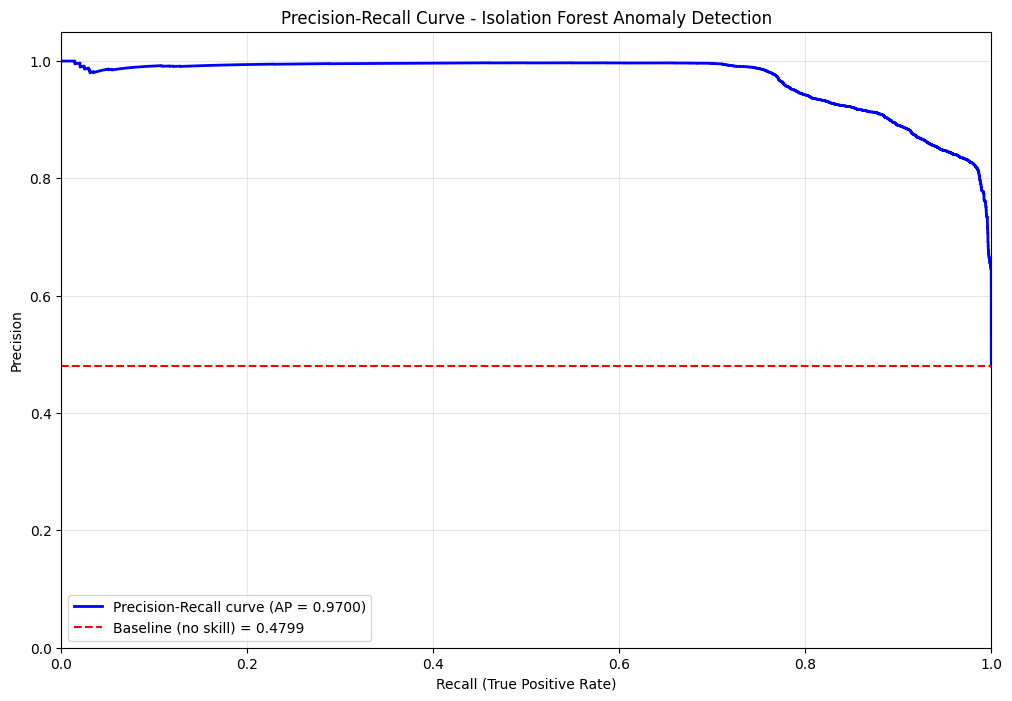

In [ ]:
from sklearn.metrics import classification_report, precision_recall_curve, average_precision_score, PrecisionRecallDisplay

# Get anomaly scores (decision function) instead of binary predictions
anomaly_scores = iso_forest.decision_function(X_test_scaled)

# Convert to positive scores (higher = more anomalous)
anomaly_scores_positive = -anomaly_scores

# Calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(true_binary, anomaly_scores_positive)
average_precision = average_precision_score(true_binary, anomaly_scores_positive)

# Calculate baseline (proportion of positives)
positive_proportion = np.sum(true_binary) / len(true_binary)

# Method 1: Manual plotting
plt.figure(figsize=(12, 8))
plt.plot(recall, precision, color='blue', lw=2,
         label=f'Precision-Recall curve (AP = {average_precision:.4f})')
plt.axhline(y=positive_proportion, color='red', linestyle='--',
            label=f'Baseline (no skill) = {positive_proportion:.4f}')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Isolation Forest Anomaly Detection')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(loc="upper right" if positive_proportion > 0.5 else "lower left")
plt.grid(True, alpha=0.3)
plt.show()


SCATTER PLOT WITH PCA DIMENSIONALITY REDUCTION


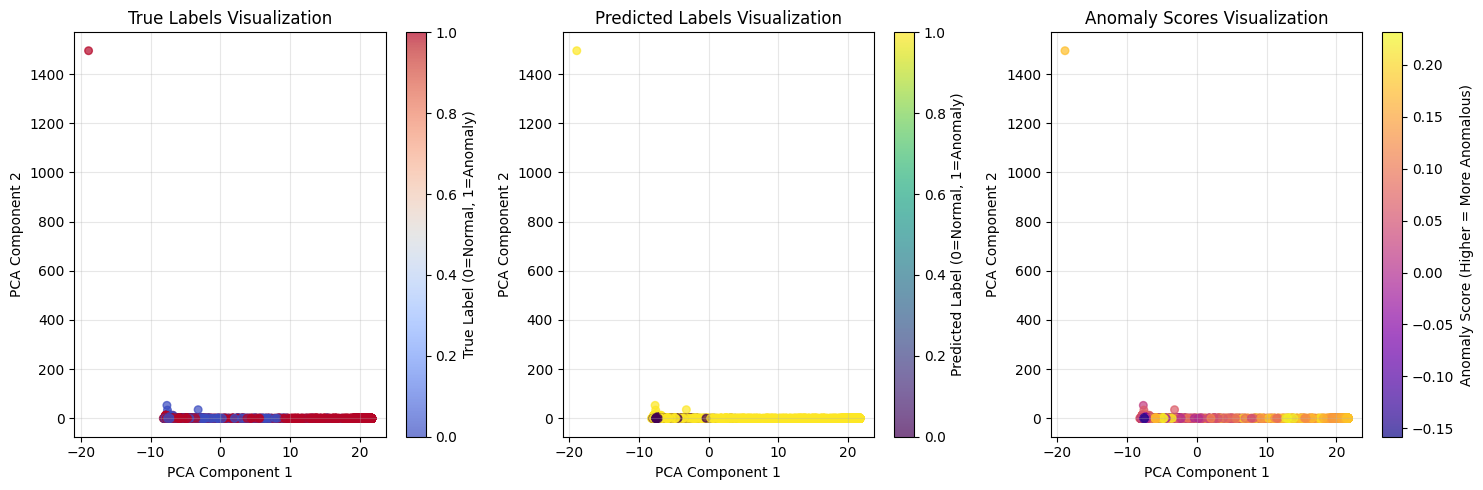

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

# Get anomaly scores for visualization
anomaly_scores = iso_forest.decision_function(X_test_scaled)
anomaly_scores_positive = -anomaly_scores  # Convert to positive (higher = more anomalous)

# Create a DataFrame for easier plotting
results_df = pd.DataFrame({
    'true_label': true_binary,
    'predicted_label': anomaly_labels,
    'anomaly_score': anomaly_scores_positive,
    'correct': [1 if true == pred else 0 for true, pred in zip(true_binary, anomaly_labels)]
})

# Method 1: Scatter plot using PCA (for high-dimensional data)
print("\n" + "="*60)
print("SCATTER PLOT WITH PCA DIMENSIONALITY REDUCTION")
print("="*60)

# Reduce to 2D using PCA
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_scaled)

plt.figure(figsize=(15, 5))

# Subplot 1: Colored by true labels
plt.subplot(1, 3, 1)
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                     c=true_binary, cmap='coolwarm', alpha=0.7, s=30)
plt.colorbar(scatter, label='True Label (0=Normal, 1=Anomaly)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('True Labels Visualization')
plt.grid(True, alpha=0.3)

# Subplot 2: Colored by predicted labels
plt.subplot(1, 3, 2)
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                     c=anomaly_labels, cmap='viridis', alpha=0.7, s=30)
plt.colorbar(scatter, label='Predicted Label (0=Normal, 1=Anomaly)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Predicted Labels Visualization')
plt.grid(True, alpha=0.3)

# Subplot 3: Colored by anomaly scores
plt.subplot(1, 3, 3)
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1],
                     c=anomaly_scores_positive, cmap='plasma', alpha=0.7, s=30)
plt.colorbar(scatter, label='Anomaly Score (Higher = More Anomalous)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Anomaly Scores Visualization')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
